In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
import holidays
import numpy as np 
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import shap
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['axes.unicode_minus'] = False  # 允许负号显示

C:\Users\79250\AppData\Local\Temp\ipykernel_12224\3051719965.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
train_df = pd.read_csv('train.csv', parse_dates=['date']).drop('id', axis=1)
test_df = pd.read_csv('test.csv', parse_dates=['date']).drop('id', axis=1) 

In [4]:
print(train_df.head())

        date country              store             product  num_sold
0 2010-01-01  Canada  Discount Stickers   Holographic Goose       NaN
1 2010-01-01  Canada  Discount Stickers              Kaggle     973.0
2 2010-01-01  Canada  Discount Stickers        Kaggle Tiers     906.0
3 2010-01-01  Canada  Discount Stickers            Kerneler     423.0
4 2010-01-01  Canada  Discount Stickers  Kerneler Dark Mode     491.0


In [5]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      230130 non-null  datetime64[ns]
 1   country   230130 non-null  object        
 2   store     230130 non-null  object        
 3   product   230130 non-null  object        
 4   num_sold  221259 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 8.8+ MB
None


In [6]:
# 缺失值
print(train_df.isnull().sum())

date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64


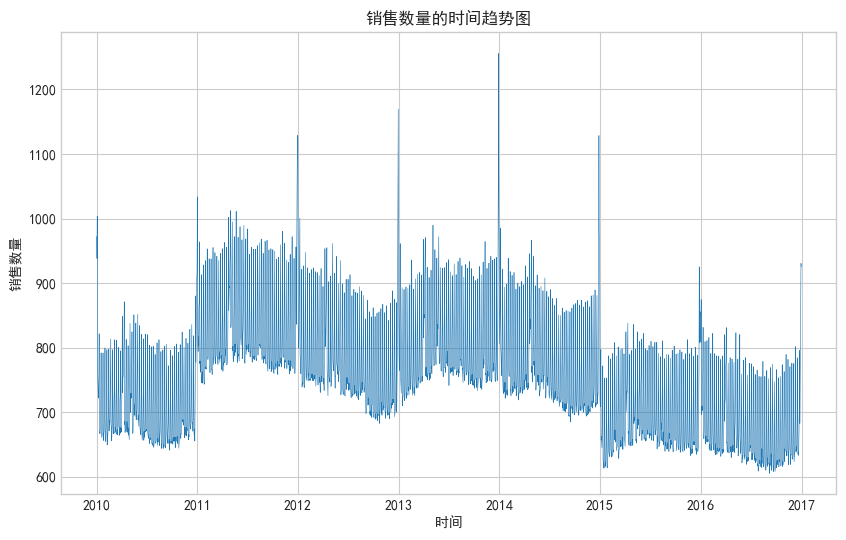

In [7]:
# 可视化
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data = train_df,
    x='date',
    y='num_sold',
    linewidth =0.4,
    errorbar=None
)
ax.set_title('销售数量的时间趋势图')
ax.set_xlabel('时间')
ax.set_ylabel('销售数量')
plt.show()

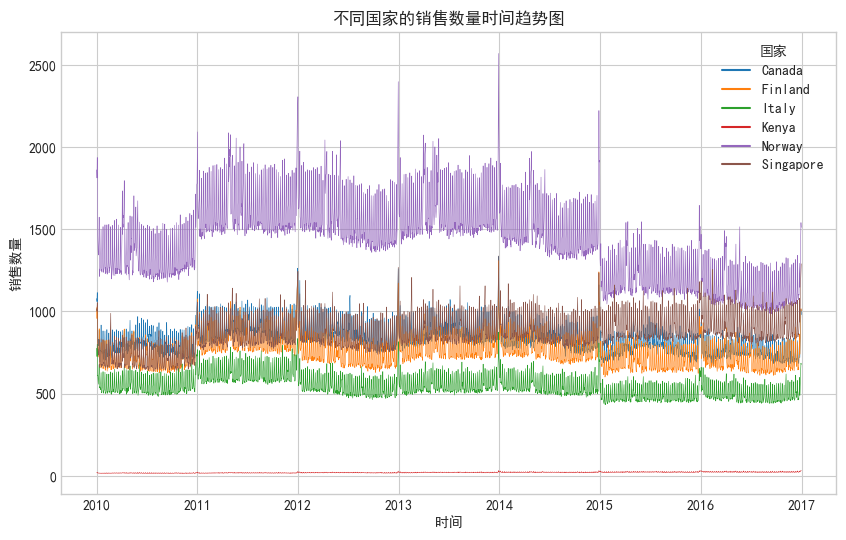

In [8]:
# 不同国家的销售量
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=train_df,
    x='date',
    y='num_sold',
    hue='country',
    linewidth=0.4,
    errorbar=None
)
ax.set_title('不同国家的销售数量时间趋势图')
ax.set_xlabel('时间')
ax.set_ylabel('销售数量')
ax.legend(title='国家')
plt.show()

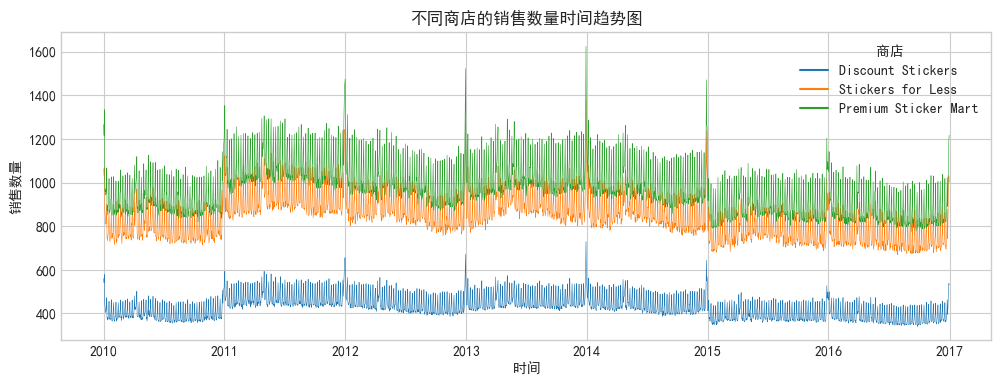

In [9]:
# 不同商店的销售量
plt.figure(figsize=(12, 4))
ax = sns.lineplot(
    data = train_df,
    x = 'date',
    y = 'num_sold',
    hue = 'store',
    linewidth = 0.4,
    errorbar = None
)
ax.set_title('不同商店的销售数量时间趋势图')
ax.set_xlabel('时间')
ax.set_ylabel('销售数量')
ax.legend(title='商店')
plt.show()

In [10]:
country = dict(
    zip((np.sort(train_df['country'].unique())), ['CA', 'FI', 'IT', 'KE', 'NO', 'SG']) # 生成一个包含国家的字典
    )
print(country)


# 节假日
holiday_dict = {
    c : holidays.country_holidays(a, years=range(2010, 2020)) # 字典的推导式
    for c, a in country.items()
}
print(holiday_dict)


{'Canada': 'CA', 'Finland': 'FI', 'Italy': 'IT', 'Kenya': 'KE', 'Norway': 'NO', 'Singapore': 'SG'}
{'Canada': {datetime.date(2016, 1, 1): "New Year's Day", datetime.date(2016, 3, 25): 'Good Friday', datetime.date(2016, 7, 1): 'Canada Day', datetime.date(2016, 9, 5): 'Labour Day', datetime.date(2016, 12, 25): 'Christmas Day', datetime.date(2016, 12, 26): 'Christmas Day (observed)', datetime.date(2017, 1, 1): "New Year's Day", datetime.date(2017, 1, 2): "New Year's Day (observed)", datetime.date(2017, 4, 14): 'Good Friday', datetime.date(2017, 7, 1): 'Canada Day', datetime.date(2017, 9, 4): 'Labour Day', datetime.date(2017, 12, 25): 'Christmas Day', datetime.date(2018, 1, 1): "New Year's Day", datetime.date(2018, 3, 30): 'Good Friday', datetime.date(2018, 7, 1): 'Canada Day', datetime.date(2018, 9, 3): 'Labour Day', datetime.date(2018, 12, 25): 'Christmas Day', datetime.date(2019, 1, 1): "New Year's Day", datetime.date(2019, 4, 19): 'Good Friday', datetime.date(2019, 7, 1): 'Canada Day',

In [11]:

# Initialize the holiday column
train_df['holiday'] = 0

# Assign holidays based on the country code
for c in holiday_dict:
    train_df.loc[train_df['country'] == c, 'holiday'] = train_df['date'].isin(holiday_dict[c]).astype(int)

print(train_df.head())

        date country              store             product  num_sold  holiday
0 2010-01-01  Canada  Discount Stickers   Holographic Goose       NaN        1
1 2010-01-01  Canada  Discount Stickers              Kaggle     973.0        1
2 2010-01-01  Canada  Discount Stickers        Kaggle Tiers     906.0        1
3 2010-01-01  Canada  Discount Stickers            Kerneler     423.0        1
4 2010-01-01  Canada  Discount Stickers  Kerneler Dark Mode     491.0        1


In [12]:
train_df.dropna()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      230130 non-null  datetime64[ns]
 1   country   230130 non-null  object        
 2   store     230130 non-null  object        
 3   product   230130 non-null  object        
 4   num_sold  221259 non-null  float64       
 5   holiday   230130 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 10.5+ MB


In [13]:
train_df['weekday_sv'] = train_df['date'].dt.strftime('%a').astype('category') # 提取周几(缩写)转换为分类变量
train_df['weekday_num'] = train_df['date'].dt.strftime('%w').astype('int') # 提取周几(数字)转换为数值变量
train_df['day_of_month'] = train_df['date'].dt.strftime('%d').astype('int') # 提取日期转换为数值变量
train_df['month_name_sv'] = train_df['date'].dt.strftime('%b').astype('category') # 提取月份(缩写)转换为分类变量
train_df['year_fv'] = train_df['date'].dt.strftime('%Y').astype('int')

In [14]:
train_df

date    country                 store             product  \
0      2010-01-01     Canada     Discount Stickers   Holographic Goose   
1      2010-01-01     Canada     Discount Stickers              Kaggle   
2      2010-01-01     Canada     Discount Stickers        Kaggle Tiers   
3      2010-01-01     Canada     Discount Stickers            Kerneler   
4      2010-01-01     Canada     Discount Stickers  Kerneler Dark Mode   
...           ...        ...                   ...                 ...   
230125 2016-12-31  Singapore  Premium Sticker Mart   Holographic Goose   
230126 2016-12-31  Singapore  Premium Sticker Mart              Kaggle   
230127 2016-12-31  Singapore  Premium Sticker Mart        Kaggle Tiers   
230128 2016-12-31  Singapore  Premium Sticker Mart            Kerneler   
230129 2016-12-31  Singapore  Premium Sticker Mart  Kerneler Dark Mode   

        num_sold  holiday weekday_sv  weekday_num  day_of_month month_name_sv  \
0            NaN        1        Fri            5             1           Jan   
1          973.0        1        Fri            5             1           Jan   
2          906.0        1        Fri            5             1           Jan   
3          423.0        1        Fri            5             1           Jan   
4          491.0        1        Fri            5             1           Jan   
...          ...      ...        ...          ...           ...           ...   
230125     466.0        0        Sat            6            31           Dec   
230126    2907.0        0        Sat            6            31           Dec   
230127    2299.0        0        Sat            6            31           Dec   
230128    1242.0        0        Sat            6            31           Dec   
230129    1622.0        0        Sat            6            31           Dec   

        year_fv  
0          2010  
1          2010  
2          2010  
3          2010  
4          2010  
...         ...  
230125     2016  
230126     2016  
230127     2016  
230128     2016  
230129     2016  

[230130 rows x 11 columns]

In [15]:
train_df.describe().round(2).style.format(precision=2).background_gradient(cmap='coolwarm') # 描述性分析，保留两位小数，背景颜色渐变

In [16]:
# 每年平均的销售量
sales_per = train_df.groupby(['year_fv'])['num_sold'].mean()
sales_per

year_fv
2010    710.779776
2011    832.307171
2012    779.019200
2013    804.180732
2014    772.103761
2015    691.562304
2016    677.567066
Name: num_sold, dtype: float64

In [17]:
df_sales = pd.DataFrame(
    {
        'Year':sales_per.index,
        'mean_sales':sales_per.values
    }
)
df_sales['Year'] = df_sales['Year'].astype('category')
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Year        7 non-null      category
 1   mean_sales  7 non-null      float64 
dtypes: category(1), float64(1)
memory usage: 459.0 bytes


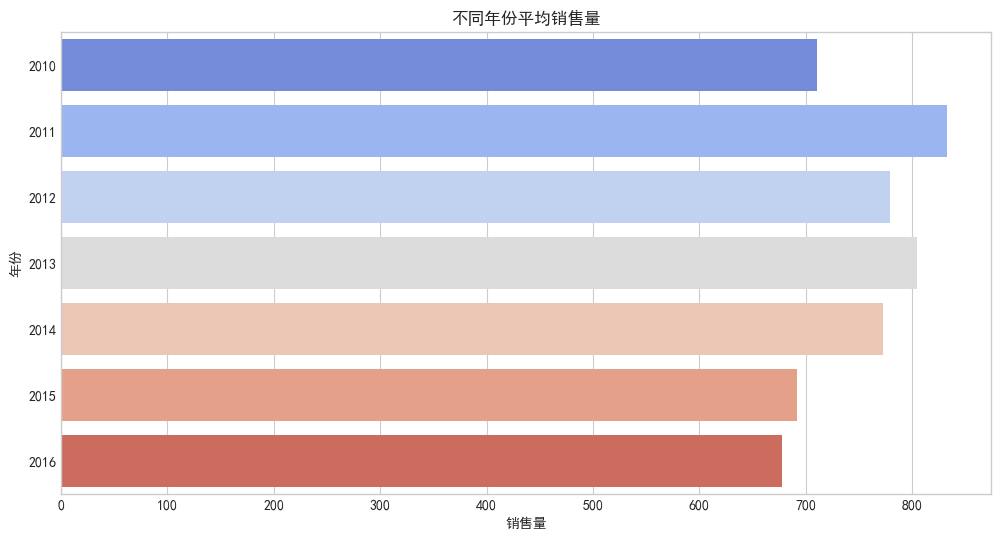

In [18]:
plt.figure(figsize=(12,6))
ax = sns.barplot(y='Year', x='mean_sales', data=df_sales, palette='coolwarm') # 没有设置年份为分类变量，导致出问题
ax.set_title('不同年份平均销售量')
ax.set_xlabel('销售量')
ax.set_ylabel('年份')
plt.show()

In [19]:
print(len(train_df['store'].unique()))

3


In [20]:
# 不同商店，每年的平均销售量
store_per_sales = train_df.groupby(['year_fv', 'store'])['num_sold'].mean()
print(type(store_per_sales))

<class 'pandas.core.series.Series'>


In [21]:
df_store_per_sales = store_per_sales.reset_index()
df_store_per_sales.columns = ['year_fv', 'store', 'value']
df_store_per_sales

year_fv                 store        value
0      2010     Discount Stickers   399.370982
1      2010  Premium Sticker Mart   926.020951
2      2010     Stickers for Less   796.324142
3      2011     Discount Stickers   470.762815
4      2011  Premium Sticker Mart  1080.338490
5      2011     Stickers for Less   930.048896
6      2012     Discount Stickers   442.811475
7      2012  Premium Sticker Mart  1005.161732
8      2012     Stickers for Less   872.075413
9      2013     Discount Stickers   458.748630
10     2013  Premium Sticker Mart  1036.936593
11     2013     Stickers for Less   898.113005
12     2014     Discount Stickers   441.790607
13     2014  Premium Sticker Mart   995.620683
14     2014     Stickers for Less   859.663766
15     2015     Discount Stickers   394.478767
16     2015  Premium Sticker Mart   894.184067
17     2015     Stickers for Less   770.994995
18     2016     Discount Stickers   386.476725
19     2016  Premium Sticker Mart   878.129217
20     2016     Stickers for Less   753.171884

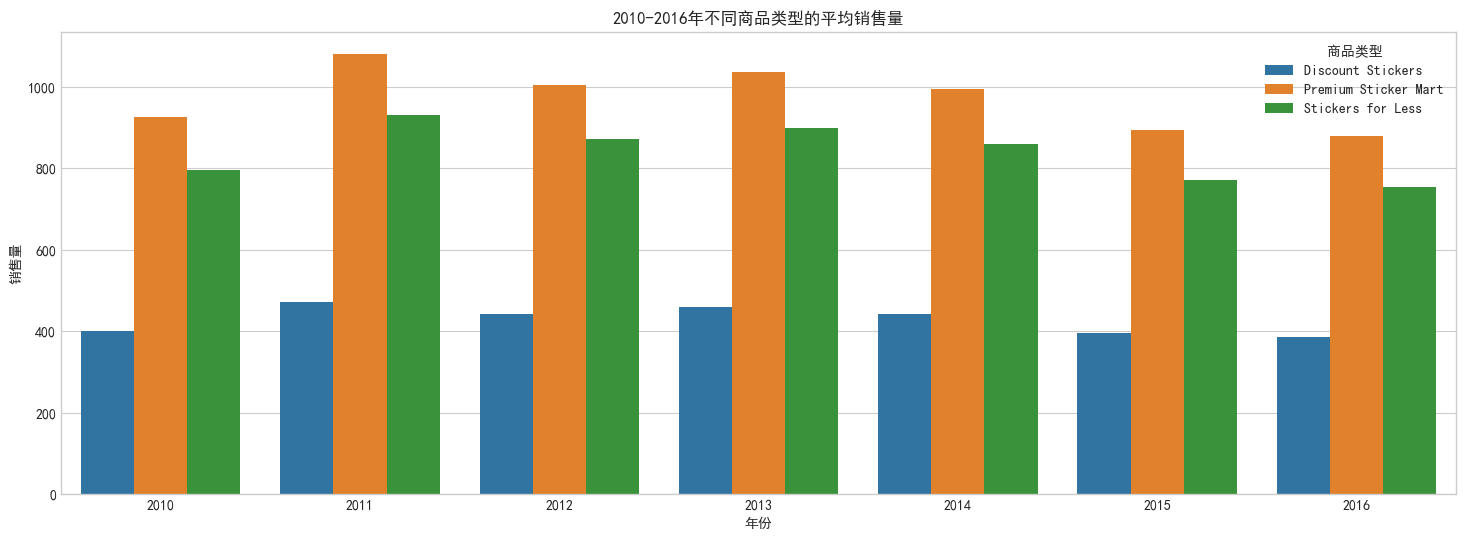

In [22]:
plt.figure(figsize=(18,6))
ax = sns.barplot(data=df_store_per_sales, x='year_fv', y='value', hue='store')
ax.set_title('2010-2016年不同商品类型的平均销售量')
ax.set_xlabel('年份')
ax.set_ylabel('销售量')
ax.legend(title='商品类型')
plt.show()

In [23]:
print(len(train_df['country'].unique()))

6


# 目标变量的可视化

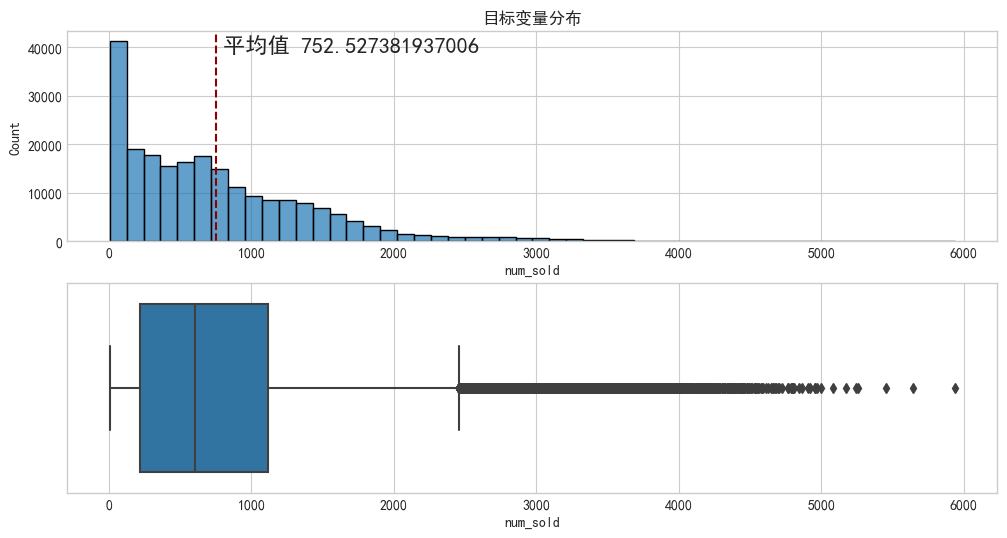

In [24]:
mean_num_sold = train_df[['num_sold']].mean().squeeze() # 计算销售数量的平均值，转成一个数
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
sns.histplot(
    data=train_df, 
    x='num_sold',
    ax=ax[0],
    bins=50,
    alpha=0.7
)
sns.boxplot(
    data=train_df, 
    x='num_sold',
    ax=ax[1]
)
ax[0].set_title('目标变量分布')
# 把平均值加到分布图里面
ax[0].axvline(x=mean_num_sold, color="darkred", ls="--", lw=1.5) # 加线
ax[0].text(
    mean_num_sold+50, # x轴的位置
    39000 ,# y轴的位置
    '平均值 ' + str(mean_num_sold),# 内容
    fontsize=16 # 字体大小
)
plt.show() # 分布图尽量用行来，列要少点，可观性强点

In [25]:
train_df['month'] = train_df['date'].dt.strftime('%b').astype('category')
train_df

date    country                 store             product  \
0      2010-01-01     Canada     Discount Stickers   Holographic Goose   
1      2010-01-01     Canada     Discount Stickers              Kaggle   
2      2010-01-01     Canada     Discount Stickers        Kaggle Tiers   
3      2010-01-01     Canada     Discount Stickers            Kerneler   
4      2010-01-01     Canada     Discount Stickers  Kerneler Dark Mode   
...           ...        ...                   ...                 ...   
230125 2016-12-31  Singapore  Premium Sticker Mart   Holographic Goose   
230126 2016-12-31  Singapore  Premium Sticker Mart              Kaggle   
230127 2016-12-31  Singapore  Premium Sticker Mart        Kaggle Tiers   
230128 2016-12-31  Singapore  Premium Sticker Mart            Kerneler   
230129 2016-12-31  Singapore  Premium Sticker Mart  Kerneler Dark Mode   

        num_sold  holiday weekday_sv  weekday_num  day_of_month month_name_sv  \
0            NaN        1        Fri            5             1           Jan   
1          973.0        1        Fri            5             1           Jan   
2          906.0        1        Fri            5             1           Jan   
3          423.0        1        Fri            5             1           Jan   
4          491.0        1        Fri            5             1           Jan   
...          ...      ...        ...          ...           ...           ...   
230125     466.0        0        Sat            6            31           Dec   
230126    2907.0        0        Sat            6            31           Dec   
230127    2299.0        0        Sat            6            31           Dec   
230128    1242.0        0        Sat            6            31           Dec   
230129    1622.0        0        Sat            6            31           Dec   

        year_fv month  
0          2010   Jan  
1          2010   Jan  
2          2010   Jan  
3          2010   Jan  
4          2010   Jan  
...         ...   ...  
230125     2016   Dec  
230126     2016   Dec  
230127     2016   Dec  
230128     2016   Dec  
230129     2016   Dec  

[230130 rows x 12 columns]

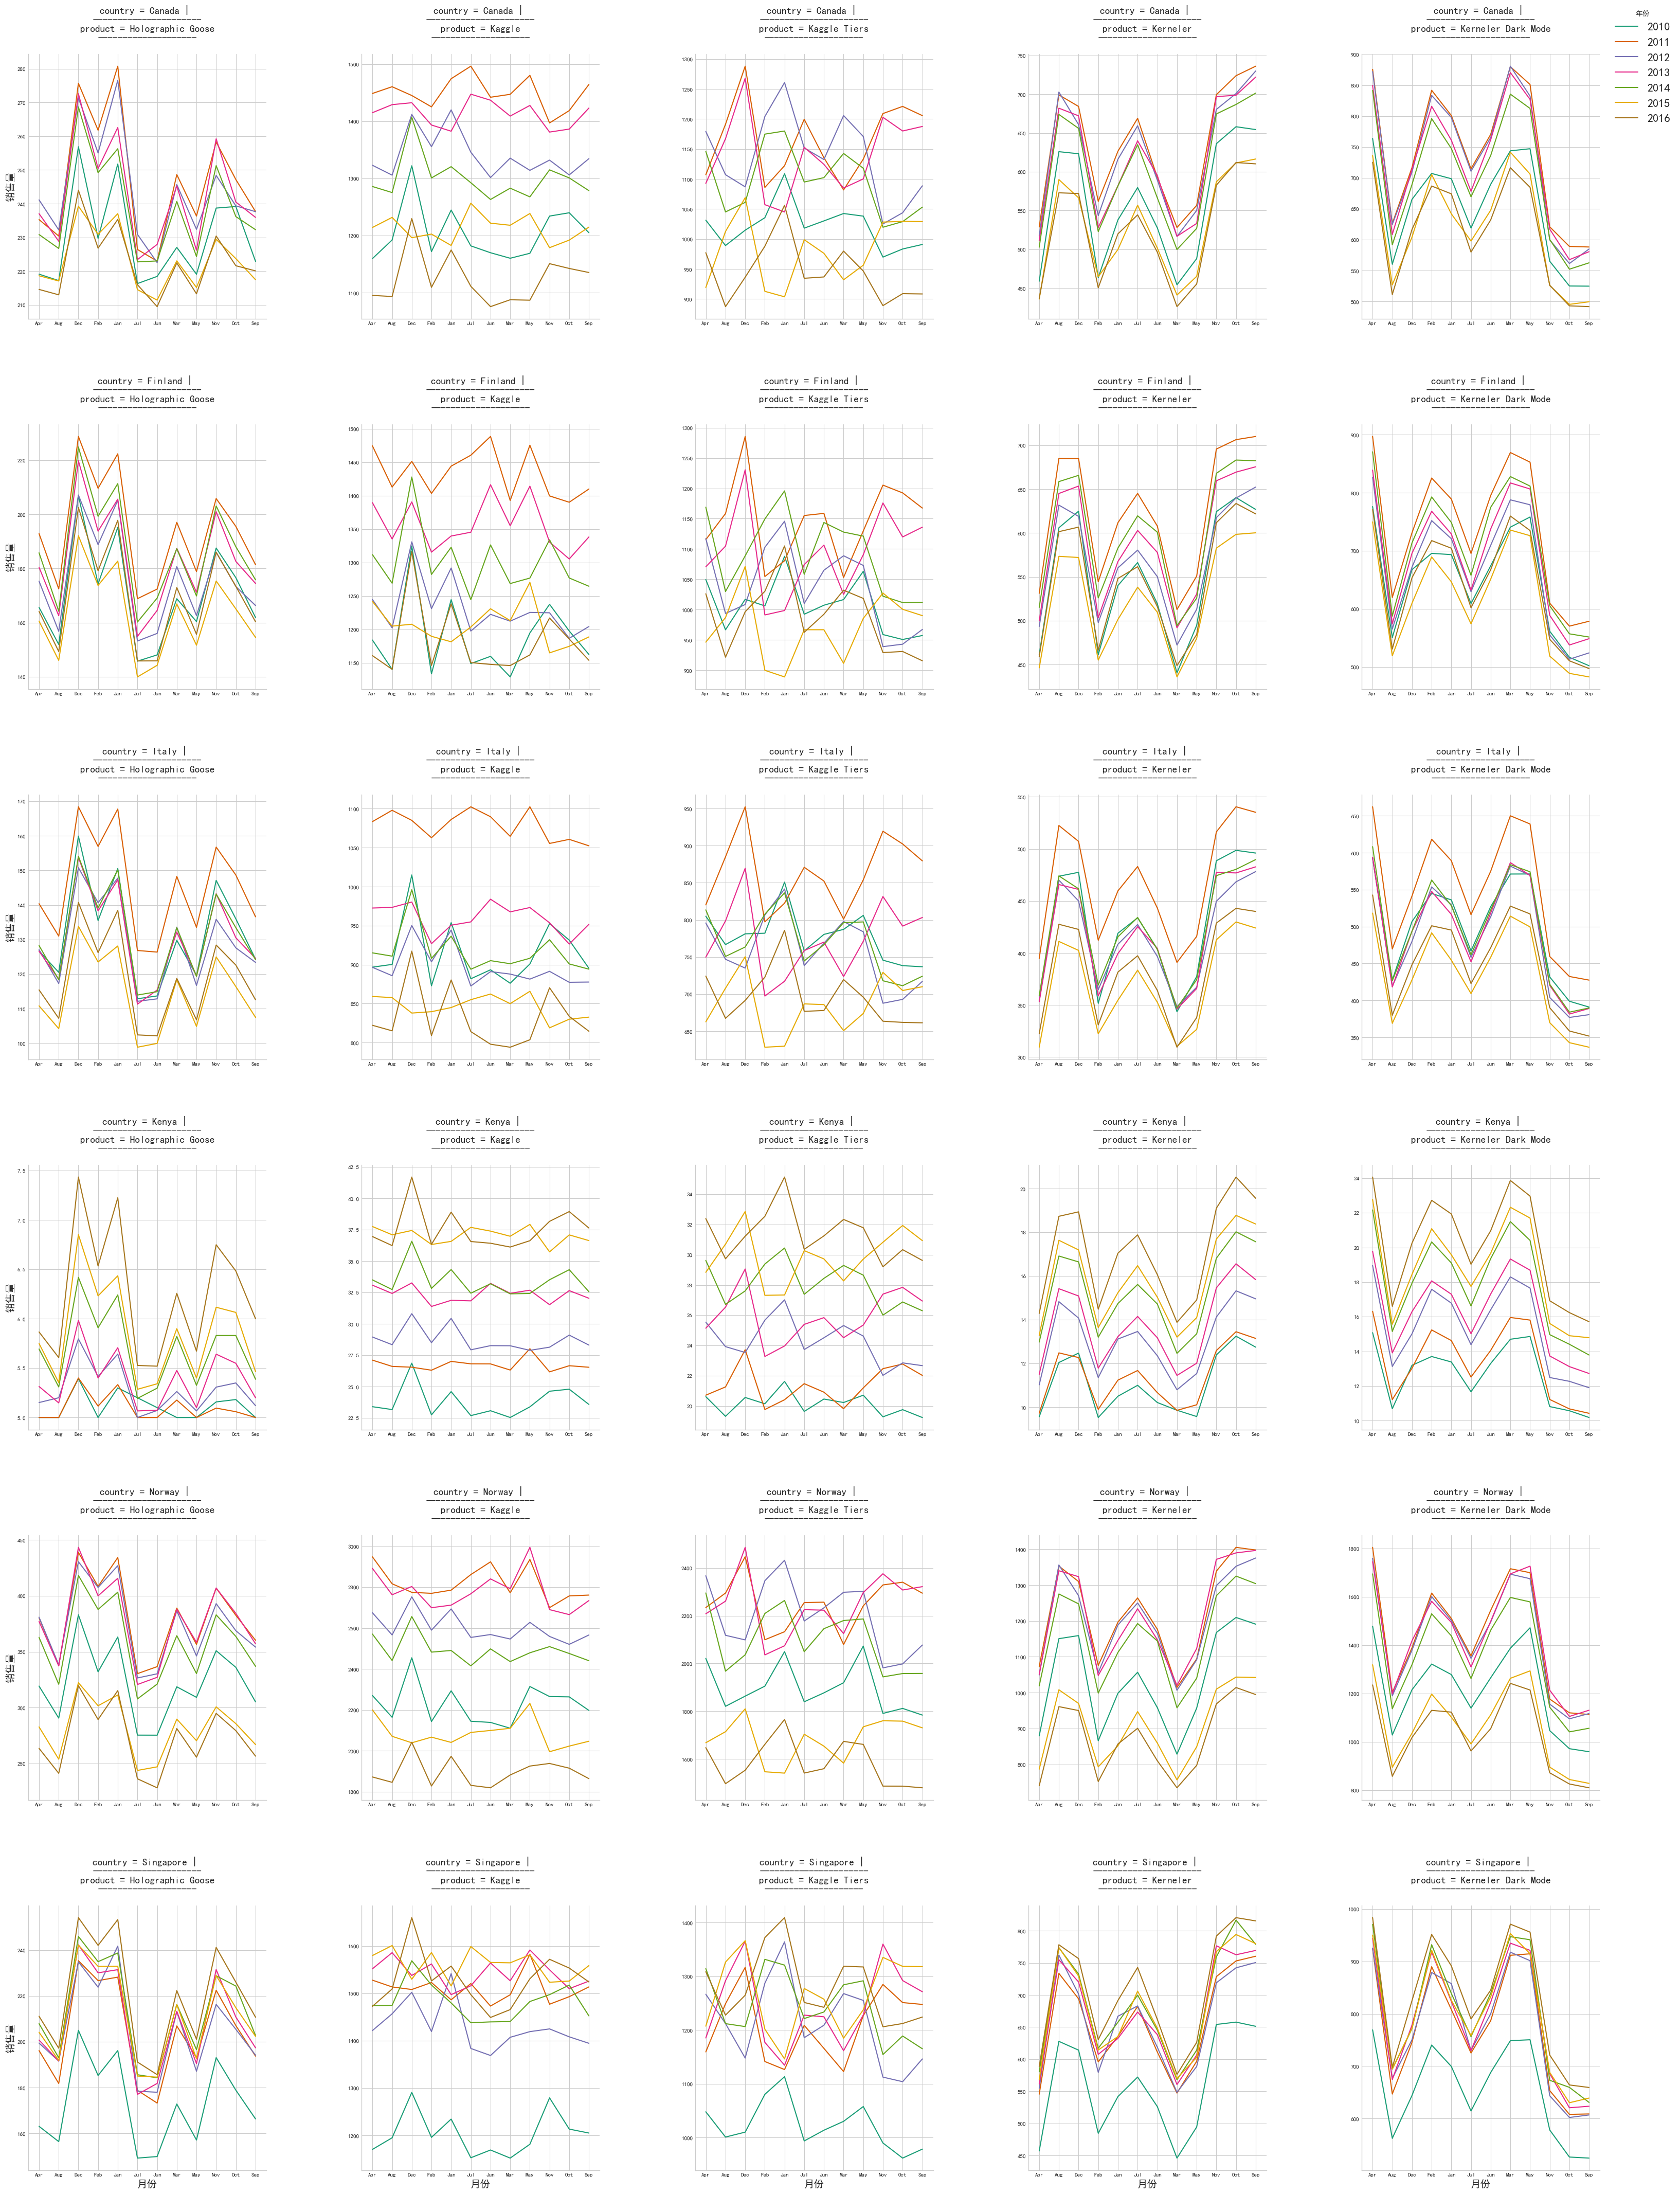

In [26]:
g = sns.FacetGrid(
    data=train_df, 
    row = 'country',
    hue = 'year_fv',
    col='product',
    palette='Dark2',
    height=7,
    aspect=0.9,
    sharex=False,
    sharey=False
) # 创建画板
g.map(sns.lineplot, 'month', 'num_sold', errorbar=None) # 绘图
g.set_titles(
    col_template='\n----------------------\n{col_var} = {col_name}\n--------------------\n',
    size=14,
) # 设置子图标题

g.add_legend(loc='upper right', title='年份', fontsize=16) #loc(设置图例的位置)

g.tick_params(labelsize=8) # 设置刻度标签大小

g.set_axis_labels(x_var='月份', y_var='销售量', fontsize=14) # 设置轴标签

plt.subplots_adjust(hspace=0.4, wspace=0.4) # 垂直间距为0.4，水平间距为0.4

plt.savefig('facegrid.png')
plt.show()

In [27]:
train_df['country'] = train_df['country'].astype('category')
train_df['store'] = train_df['store'].astype('category')
train_df['product'] = train_df['product'].astype('category')

In [28]:
y = train_df.num_sold
X = train_df.drop(['num_sold', 'date'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42
)
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "d:\anaconda\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "d:\anaconda\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "d:\anaconda\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc1 in position 24: invalid start byte
  File "d:\anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 202, in _count_physical_cores
    cpu_info = cpu_info.stdout.splitlines()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 10
[LightGBM] [Info] Start training from score 723.110079


LGBMRegressor()

In [29]:
shap_explainer = shap.TreeExplainer(model, feature_perturbation='tree_path_dependent') # 创建解释器 ,TreeExplainer可以接受类别变量，指定feature_perturb = True
shap_values = shap_explainer.shap_values(X_test)

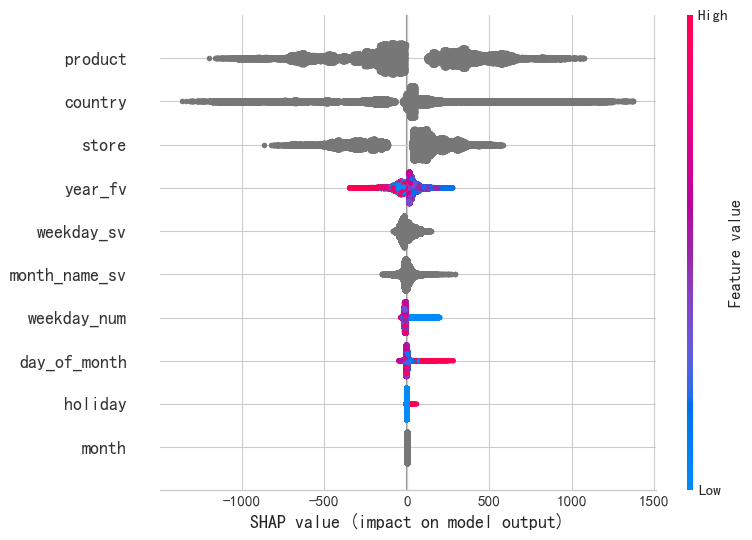

In [30]:
shap.summary_plot(shap_values, X_test) # 每个特征对模型预测的重要性

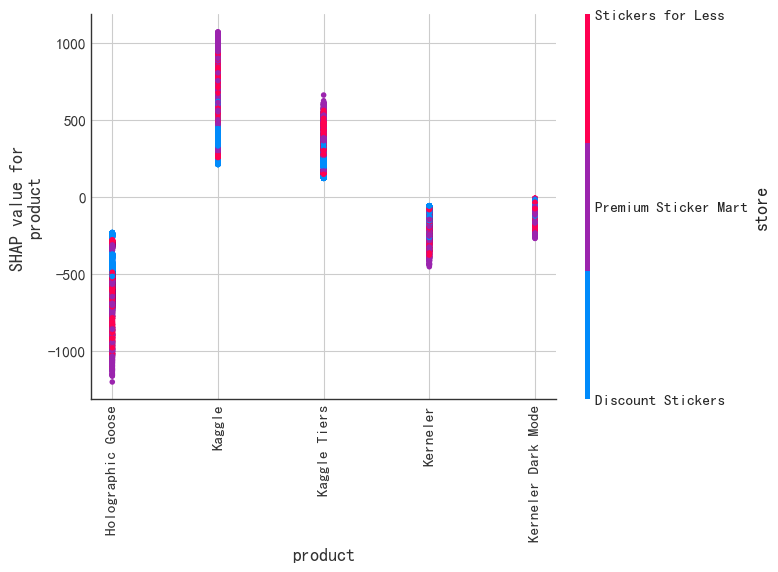

In [31]:
shap.dependence_plot('product', shap_values, X_test) # 展示某个特征的 SHAP 值与其取值之间的关系。

In [32]:
shap_explanation = shap.Explanation(values=shap_values, base_values=shap_explainer.expected_value, data=X_test)

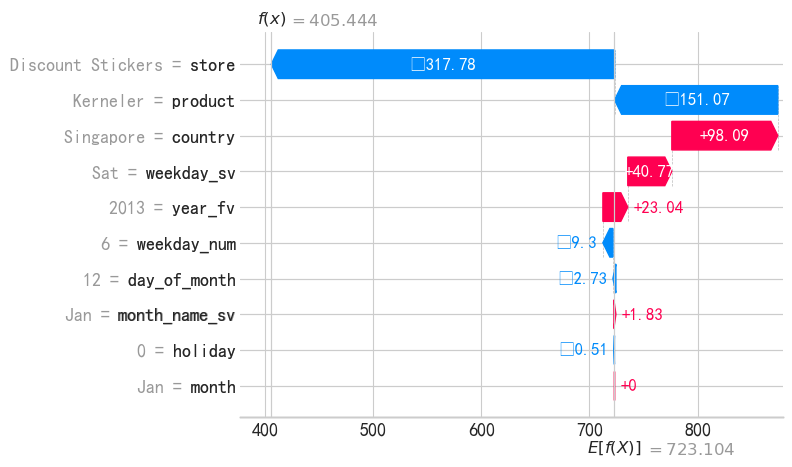

In [33]:
index = 100
shap.plots.waterfall(shap_explanation[index], max_display=18,  show=False)
fig, ax = plt.gcf(), plt.gca()
fig.set_figheight(5)
fig.set_figwidth(7)
plt.show()